In [2]:
import pandas as pd
import os
from datetime import datetime
import sqlite3
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence 


%matplotlib inline

In [3]:
# function to convert datetime object to 4 - for force ONLY
def datetime(df, col_as_str):
    yearmonthday = df[col_as_str].astype(str).str.split(" ")
    ymd = yearmonthday.apply(lambda x: x[0]).str.split("/")
    year = ymd.apply(lambda x: x[2])
    month = ymd.apply(lambda x: x[0])
    day = ymd.apply(lambda x: x[1])
    time = ymd = yearmonthday.apply(lambda x: x[1]+x[2]).astype(str)
    df["year"] = year
    df["month"] = month
    df["day"] = day
    df["time"] = time
    return df


In [4]:
'''def callstime(df, col_arrive):
    yearmonthday = df[col_arrive].astype(str).str.split(" ")
    df["year"] = yearmonthday.apply(lambda x: x[2])
    df["day"] = yearmonthday.apply(lambda x: x[1])
    month_dict = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6, "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec":12}
    df["month"] = yearmonthday.apply(lambda x: month_dict[x[0]])
    df["time"] = yearmonthday.apply(lambda x: x[3])
    return df'''
    
    

'def callstime(df, col_arrive):\n    yearmonthday = df[col_arrive].astype(str).str.split(" ")\n    df["year"] = yearmonthday.apply(lambda x: x[2])\n    df["day"] = yearmonthday.apply(lambda x: x[1])\n    month_dict = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6, "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec":12}\n    df["month"] = yearmonthday.apply(lambda x: month_dict[x[0]])\n    df["time"] = yearmonthday.apply(lambda x: x[3])\n    return df'

In [5]:
'''#don't need to run again - all are associated to establish SQL table
calls = pd.read_csv("data/Call_Data.csv")
calls = callstime(calls,"Arrived Time")
calls17 = calls[calls["year"].isin(["2014", "2015", "2016", "2017", "2018", "2019"])]
calls17["epoch_calls"] = epoch_second2'''

'''# remove repetitive columns

calls_tosql = calls17.drop(columns =["year","day", "month", "time", "Precinct", "Sector", "Arrived Time"])
calls_tosql.set_index("epoch_calls", inplace=True)
'''

# move calls to sqlite table - DONT REPEAT
# calls_tosql.to_sql("log", con=cnx, index=True)
'''
# calculate and add column for epoch time
bar = pd.to_datetime( calls17["Arrived Time"], format="%b %d %Y %I:%M:%S:%f%p" )
epoch_second2 = bar.map(lambda x: x.value/1e9)'''


'\n# calculate and add column for epoch time\nbar = pd.to_datetime( calls17["Arrived Time"], format="%b %d %Y %I:%M:%S:%f%p" )\nepoch_second2 = bar.map(lambda x: x.value/1e9)'

In [11]:
'''# iterate through the dataframe calls17 and remove repeated CAD numbers

_row = []
#val_lst = []
for ix, row in calls17.iterrows():
    # query the 911 calls database
    # for each call, append to a bunch of records that we're building up into a dataframe
    CAD = row["CAD Event Number"]
    EC = row['Event Clearance Description']
    if (CAD in two) and (EC == '-'):
        _row.append(ix)
_row'''

'# iterate through the dataframe calls17 and remove repeated CAD numbers\n\n_row = []\n#val_lst = []\nfor ix, row in calls17.iterrows():\n    # query the 911 calls database\n    # for each call, append to a bunch of records that we\'re building up into a dataframe\n    CAD = row["CAD Event Number"]\n    EC = row[\'Event Clearance Description\']\n    if (CAD in two) and (EC == \'-\'):\n        _row.append(ix)\n_row'

In [104]:
force = pd.read_csv("data/Use_Of_Force.csv")
len(force) -  len(force[force["Beat"] == '-'])

9422

In [105]:
# change to epoch time
force = datetime(force,"Occured_date_time" )
foo = pd.to_datetime( force.Occured_date_time )
epoch_second = foo.map(lambda x:x.value/1e9)

force["epoch"] = epoch_second


In [106]:
# remove repetitive columns (incident type, officer id and subject id are in ID respectively)

force = force.drop(columns=["Occured_date_time", "ID"])


In [107]:
force.columns

Index(['Incident_Num', 'Incident_Type', 'Precinct', 'Sector', 'Beat',
       'Officer_ID', 'Subject_ID', 'Subject_Race', 'Subject_Gender', 'year',
       'month', 'day', 'time', 'epoch'],
      dtype='object')

In [108]:
force["Incident_Type"].value_counts()
#force[force["Incident_Num"] == 14888]
# level 2 - 67 "-"
# OIS - 5 (2 subjects, 2 days)
# level 1 - 344 (249 subject_IDs)
# level 3 - None

Level 1 - Use of Force    7474
Level 2 - Use of Force    2185
Level 3 - Use of Force     105
Level 3 - OIS               74
Name: Incident_Type, dtype: int64

In [122]:
# so the question is ... are these each a separate thing?

f = force[force["Incident_Type"] == "Level 3 - Use of Force"]
f2 = f[f["Beat"] == '-']
f2.Subject_ID.value_counts()

Series([], Name: Subject_ID, dtype: int64)

In [95]:
# create engine
cnx = sqlite3.connect('calls.sqlite')

In [96]:
# create cursor
cur = cnx.cursor()


In [97]:
# iterate through the dataframe 'force', make a bunch of new rows, and then make a dataframe out of those

new_row = []
#val_lst = []
for ix, row in force.iterrows():
    # query the 911 calls database
    # for each call, append to a bunch of records that we're building up into a dataframe
    value = row.epoch
    rowbeat = row.Beat
    vals = cur.execute(f"select * from log where epoch_calls BETWEEN ({value} - 2400) AND {value} ").fetchall()
    #val_lst.extend([value, val[0]])
    cnx.commit()
    
    for val in vals:
        new_row.extend( [[ix,  val[0], row.epoch, row.Incident_Num, row.Officer_ID, row.Subject_ID, val[1], val[2],
                        row.Incident_Type, row.Precinct, 
                        row.Sector, row.Beat, val[8], val[4],
                        row.Subject_Race, row.Subject_Gender, val[3], val[5], val[6], 
                        val[7], row.year, row.month, row.day, row.time] ])
  

In [21]:
# look at force - are beat and officer correlated?
#force.info()
#force.groupby("Officer_ID")[["Beat"]].sum()

# officer may be at more than one beat

In [98]:
merged = pd.DataFrame(new_row, columns=["index","call_epoch", "force_epoch", "Incident_Num", "Officer_ID",
                                        "Subject_ID", "CAD_Event_Number", "Event_Clearance_Description",
                                "Force_Level", "Precinct", 
                                "Sector", "force_beat", "calls_beat", "Priority",
                                "Subject_Race", "Subject_Gender","Call_Type", "Initial_Call_Type", "Final_Call_Type",
                                "Original_Time_Queued", "year", "month","day", "time " ])



In [99]:
len(merged)
len(merged[merged["force_beat"] == '-'])



10478

In [100]:
new_merged = []
for ix, row in merged.iterrows():
    forc = row.force_beat
    cal = row.calls_beat
    if forc != '-':
        if forc != cal:
            pass
        else:
            new_merged.append(row)
    else:
        new_merged.append(row)

In [101]:
new_merged = pd.DataFrame(new_merged)


In [102]:
len(new_merged) - len(new_merged[new_merged["force_beat"] == '-'])

6721

In [23]:
merged.call_epoch = pd.to_numeric(merged.call_epoch, downcast="integer")
merged.force_epoch = pd.to_numeric(merged.force_epoch, downcast="integer")

In [24]:
dfrs = merged["CAD_Event_Number"].value_counts()
two = []
for v, i in zip(dfrs.values, dfrs.index):
    if v >1:
        two.append(i)
# len(two) == 362  
s = [x > 1 for x in dfrs]
dd =dfrs[s]

t = merged[merged["CAD_Event_Number"].isin(two)]
indicest = t[t["Event_Clearance_Description"] == "-"].index
indicest

merged.drop(indicest, axis=0, inplace=True)

In [25]:
# make numeric
rev_df = merged.replace("-1", -1)
rev_df["time"] = pd.to_datetime(rev_df["time "])
rev_df["Original_Time_Queued"] = pd.to_datetime(rev_df["Original_Time_Queued"])
rev_df["time"].apply(lambda x: pd.datetime.strftime(x, '%H:%M:%S'))

rev_df.head()


,index,call_epoch,force_epoch,Incident_Num,Officer_ID,Subject_ID,CAD_Event_Number,Event_Clearance_Description,Force_Level,Precinct,...,Subject_Gender,Call_Type,Initial_Call_Type,Final_Call_Type,Original_Time_Queued,year,month,day,time,time
0,0,1511833107,1511833200,18412,2238,14470,2017000438597,REPORT WRITTEN (NO ARREST),Level 1 - Use of Force,-,...,Female,"TELEPHONE OTHER, NOT 911","SUSPICIOUS PERSON, VEHICLE OR INCIDENT",--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,2017-11-28 01:27:55,2017,11,28,01:40:00AM,2019-07-03 01:40:00
1,2,1532199428,1532199480,30638,2146,17272,2018000269265,UNABLE TO LOCATE INCIDENT OR COMPLAINANT,Level 1 - Use of Force,-,...,Male,911,TRAFFIC - BLOCKING ROADWAY,--TRAFFIC - BLOCKING TRAFFIC,2018-07-21 17:38:10,2018,07,21,06:58:00PM,2019-07-03 18:58:00
2,3,1542460631,1542460740,37423,2484,18496,2018000431132,REPORT WRITTEN (NO ARREST),Level 1 - Use of Force,-,...,Female,"TELEPHONE OTHER, NOT 911","MVC - HIT AND RUN (NON INJURY), INCLUDES IP/JO",--TRAFFIC - MV COLLISION INVESTIGATION,2018-11-17 12:21:26,2018,11,17,01:19:00PM,2019-07-03 13:19:00
3,3,1542460719,1542460740,37423,2484,18496,2018000431200,REPORT WRITTEN (NO ARREST),Level 1 - Use of Force,-,...,Female,911,"MVC - NON INJURY, BLOCKING",--TRAFFIC - MV COLLISION INVESTIGATION,2018-11-17 13:07:44,2018,11,17,01:19:00PM,2019-07-03 13:19:00
4,3,1542460729,1542460740,37423,2484,18496,2018000431212,CITATION ISSUED (CRIMINAL OR NON-CRIMINAL),Level 1 - Use of Force,-,...,Female,ONVIEW,PARKING VIOLATION (EXCEPT ABANDONED CAR),--TRAFFIC - PARKING VIOL (EXCEPT ABANDONED CAR),2018-11-17 13:18:49,2018,11,17,01:19:00PM,2019-07-03 13:19:00


In [26]:
# make second df and keep leaky data for exploration later
# take out event description and final call (bc you wouldn't know)
rev_df_leaky = rev_df.copy(deep=True)
type(rev_df_leaky)

pandas.core.frame.DataFrame

In [27]:
rev_df = pd.get_dummies(data = rev_df, 
                     columns=["force_beat","Force_Level", "calls_beat", 
                              "Subject_Gender", "Call_Type","Subject_Race", "Initial_Call_Type", 
                             "Precinct", "Sector", "Officer_ID", "Subject_ID"], 
                     prefix=["forceb", "forcelevel", "callsb",  
                             "Gender", "CallType", "Race", "InitCall", 
                            "Precinct","Sector", "OID", "SID" ])



# pd.get_dummies(data=df, columns=['A', 'B'])
                      

In [28]:

rev_df["year"] = rev_df["year"].astype(int)
rev_df["month"] = rev_df["month"].astype(int)
rev_df["day"] = rev_df["day"].astype(int)
rev_df["day_of_week"] = rev_df.Original_Time_Queued.dt.dayofweek


In [29]:
rev_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10915 entries, 0 to 10925
Data columns (total 4637 columns):
index                                                          int64
call_epoch                                                     int64
force_epoch                                                    int64
Incident_Num                                                   int64
CAD_Event_Number                                               int64
Event_Clearance_Description                                    object
Priority                                                       int64
Final_Call_Type                                                object
Original_Time_Queued                                           datetime64[ns]
year                                                           int64
month                                                          int64
day                                                            int64
time                                              

In [30]:
# drop leaky data
rev_df.drop(["Event_Clearance_Description","Final_Call_Type", "time ", "index"], axis=1, inplace=True )

In [19]:
'''# exploring unsupervised learning

# make appropriate array to use SVD
svdf = rev_df.drop(["time", "Original_Time_Queued"], axis=1)
sdf = svdf.iloc[:10000, :]'''

'# exploring unsupervised learning\n\n# make appropriate array to use SVD\nsvdf = rev_df.drop(["time", "Original_Time_Queued"], axis=1)\nsdf = svdf.iloc[:10000, :]'

In [20]:
'''u, s, vh = np.linalg.svd(sdf)'''
'''power = s*2
total_power = sum(power)
total_power'''
'''vh.shape, s.shape, u.shape, svdf.shape'''
'''svV  = pd.DataFrame(vh[:10])
svV.columns = svdf.columns
svV'''
'''sv0 = svV.iloc[0,:]
sv0 = abs(sv0)
np.argmax(sv0)
sv0[6] # equals CAD_Event_Number
#svV.iloc[0,:]'''



'sv0 = svV.iloc[0,:]\nsv0 = abs(sv0)\nnp.argmax(sv0)\nsv0[6] # equals CAD_Event_Number\n#svV.iloc[0,:]'

In [21]:
#rev_df.info(verbose=True)

rev_df['call_hour'] = rev_df.Original_Time_Queued.apply(lambda x: x.hour)
rev_df['arrive_hour'] = rev_df.time.apply(lambda x: x.hour)
rev_df['time_to_arrival'] = rev_df["arrive_hour"] - rev_df["call_hour"]
rev_df.drop("arrive_hour", axis=1, inplace=True)

In [22]:
# dataframe rev_df before dropping CAD dupes
rev_df_orig = rev_df.copy(deep=True)

In [23]:
'''# removed ECD - previous iteration
dfrs = rev_df["CAD_Event_Number"].value_counts()
two = []
for v, i in zip(dfrs.values, dfrs.index):
    if v >1:
        two.append(i)
# len(two) == 362  
s = [x > 1 for x in dfrs]
dd =dfrs[s]

ts = rev_df[rev_df["CAD_Event_Number"].isin(two)]
indices = ts[ts["ECD_-"] == 1].index
indices

rev_df.drop(indices, axis=0, inplace=True)'''

'# removed ECD - previous iteration\ndfrs = rev_df["CAD_Event_Number"].value_counts()\ntwo = []\nfor v, i in zip(dfrs.values, dfrs.index):\n    if v >1:\n        two.append(i)\n# len(two) == 362  \ns = [x > 1 for x in dfrs]\ndd =dfrs[s]\n\nts = rev_df[rev_df["CAD_Event_Number"].isin(two)]\nindices = ts[ts["ECD_-"] == 1].index\nindices\n\nrev_df.drop(indices, axis=0, inplace=True)'

In [24]:
#rev_df.drop(indicest, axis=0, inplace=True)

len(rev_df_leaky), len(rev_df), len(merged)

(27007, 27007, 27007)

In [25]:
'''# make smaller df for scatter_matrix
sm = rev_df[['Precinct_W', 'Race_Black or African American', 'Race_White',
       'Gender_Male', 'Gender_Female', 'Priority', 'year', 'day_of_week',
       'month', 'day']]

pd.plotting.scatter_matrix(sm, alpha=0.2, figsize=(24,24));'''

"# make smaller df for scatter_matrix\nsm = rev_df[['Precinct_W', 'Race_Black or African American', 'Race_White',\n       'Gender_Male', 'Gender_Female', 'Priority', 'year', 'day_of_week',\n       'month', 'day']]\n\npd.plotting.scatter_matrix(sm, alpha=0.2, figsize=(24,24));"

In [26]:
#calls17[calls17["CAD Event Number"] == 2014000119510][["Beat"]]

In [27]:
# decided not to use this, as it is info I may want
event_lst = ["CITATION ISSUED (CRIMINAL OR NON-CRIMINAL) ",
"PHYSICAL ARREST MADE",
"OTHER REPORT MADE" ,
"FOLLOW-UP REPORT MADE",
"PROBLEM SOLVING PROJECT" ,
"STREET CHECK WRITTEN ",
"INCIDENT LOCATED, PUBLIC ORDER RESTORED ",
"TRANSPORTATION OR ESCORT PROVIDED", 
"-",
"SERVICE OF DVPA ORDER",
"RADIO BROADCAST AND CLEAR",
"NON-CRIMINAL REFERRAL",
"EXTRA UNIT" ,
"(NOT CURRENTLY USED) ALARM NO RESPONSE" ] 

In [28]:
clf = RandomForestClassifier(n_estimators=100, random_state=659, oob_score=True)



In [29]:
rev_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27007 entries, 0 to 27037
Data columns (total 5372 columns):
call_epoch                                                     int64
force_epoch                                                    int64
Incident_Num                                                   int64
CAD_Event_Number                                               int64
Priority                                                       int64
Original_Time_Queued                                           datetime64[ns]
year                                                           int64
month                                                          int64
day                                                            int64
time                                                           datetime64[ns]
forceb_-                                                       uint8
forceb_99                                                      uint8
forceb_B1                                  

In [31]:
rev = rev_df.drop([ "call_epoch", "force_epoch", "Incident_Num", "CAD_Event_Number", "Original_Time_Queued", "time",
                "forcelevel_Level 1 - Use of Force", "forcelevel_Level 2 - Use of Force", "forcelevel_Level 3 - OIS",
                "forcelevel_Level 3 - Use of Force"], axis=1)
cols = rev.columns

In [32]:
type(rev)

pandas.core.frame.DataFrame

In [39]:
# X for classifier
X = rev

#X.info(verbose=True)
type(X)

pandas.core.frame.DataFrame

In [34]:
X_scaled = StandardScaler().fit_transform(X)

In [40]:
type(X_scaled)

numpy.ndarray

In [35]:
y = merged.Force_Level
y.replace({"Level 1 - Use of Force":1,"Level 2 - Use of Force":2,"Level 3 - OIS":4, "Level 3 - Use of Force": 3 })
y.shape, X_scaled.shape

((10915,), (10915, 4623))

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=659)


In [46]:
test = rev.loc[y_test.index[0]]
test[test > 0]

Priority                                                  2
year                                                   2018
month                                                     6
day                                                      21
forceb_M3                                                 1
callsb_J1                                                 1
Gender_Male                                               1
CallType_911                                              1
Race_Black or African American                            1
InitCall_CHILD - ABAND, ABUSED, MOLESTED, NEGLECTED       1
Precinct_W                                                1
Sector_M                                                  1
OID_2238                                                  1
SID_16959                                                 1
day_of_week                                               3
Name: 8477, dtype: int64

In [36]:
clf.fit(X_train, y_train ) #takes three minutes

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=659, verbose=0,
                       warm_start=False)

In [37]:
len(clf.feature_importances_), len(cols)

(5362, 5362)

In [38]:
# most important features
indices = np.argsort(clf.feature_importances_)
big = indices[-10:]

cols[big]

Index(['Race_White', 'Gender_Male', 'Gender_Female', 'time_to_arrival',
       'Priority', 'year', 'day_of_week', 'call_hour', 'month', 'day'],
      dtype='object')

In [1]:
X[X.isin(X_test[0])]

NameError: name 'X' is not defined

In [39]:
# least important features
little = indices[:20]
cols[little]


Index(['SID_11424', 'InitCall_ABDUCTION - IP/JO - UNK KIDNAPPING', 'SID_11415',
       'SID_14803', 'SID_16598', 'SID_11405', 'SID_14471', 'SID_11366',
       'InitCall_ASLT - PERSON SHOT OR SHOT AT', 'SID_14456', 'SID_2605',
       'SID_1370', 'SID_18200', 'SID_2598', 'SID_506', 'SID_500', 'OID_113',
       'SID_5777', 'SID_14449', 'SID_11186'],
      dtype='object')

In [40]:
clf.oob_score_ # accuracy of training set

0.964498958574404

In [41]:
yhat = clf.predict(X_test)

In [42]:
sum(yhat == y_test) / len(yhat) # accuracy of testing set

0.9661236579044798

In [43]:
pp = clf.predict_proba(X_test)

In [101]:
clf.classes_

array(['Level 1 - Use of Force', 'Level 2 - Use of Force',
       'Level 3 - OIS', 'Level 3 - Use of Force'], dtype=object)

In [103]:
for p in pp[:10]:
    print(f"Pr of Force 1 is: {p[0]}, Pr of Force 2: {p[1]}, Pr of Force 3: {p[3]}, & Pr of Officer Involved Shooting: {p[2]}")
          
          

Pr of Force 1 is: 0.91, Pr of Force 2: 0.06, Pr of Force 3: 0.02, & Pr of Officer Involved Shooting: 0.01
Pr of Force 1 is: 0.68, Pr of Force 2: 0.31, Pr of Force 3: 0.01, & Pr of Officer Involved Shooting: 0.0
Pr of Force 1 is: 0.97, Pr of Force 2: 0.02, Pr of Force 3: 0.01, & Pr of Officer Involved Shooting: 0.0
Pr of Force 1 is: 0.85, Pr of Force 2: 0.15, Pr of Force 3: 0.0, & Pr of Officer Involved Shooting: 0.0
Pr of Force 1 is: 0.21, Pr of Force 2: 0.57, Pr of Force 3: 0.22, & Pr of Officer Involved Shooting: 0.0
Pr of Force 1 is: 0.99, Pr of Force 2: 0.01, Pr of Force 3: 0.0, & Pr of Officer Involved Shooting: 0.0
Pr of Force 1 is: 0.97, Pr of Force 2: 0.03, Pr of Force 3: 0.0, & Pr of Officer Involved Shooting: 0.0
Pr of Force 1 is: 0.01, Pr of Force 2: 0.99, Pr of Force 3: 0.0, & Pr of Officer Involved Shooting: 0.0
Pr of Force 1 is: 0.94, Pr of Force 2: 0.06, Pr of Force 3: 0.0, & Pr of Officer Involved Shooting: 0.0
Pr of Force 1 is: 0.99, Pr of Force 2: 0.01, Pr of Force 3:

In [105]:
X_test[:10]

array([[ 1.3406332 , -0.19332205, -0.74300086, ..., -0.01750014,
        -0.00783539, -0.0448786 ],
       [ 1.3406332 ,  0.45125184,  0.16846498, ..., -0.52789573,
        -1.90003024, -0.0448786 ],
       [-1.13482613,  0.45125184,  1.07993081, ...,  1.51368662,
        -1.90003024, -0.0448786 ],
       ...,
       [-0.72224958, -1.48246982, -0.74300086, ..., -1.5486869 ,
        -0.4808841 , -0.0448786 ],
       [ 0.51548009,  0.45125184,  0.47228692, ..., -1.03829131,
         0.14984751,  0.25453752],
       [-0.30967302,  1.09582573,  0.47228692, ...,  0.49289545,
         1.25362784,  0.25453752]])

In [45]:
# need to do gradient boosting to do partial dependency plotting
gdbr = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                  max_depth=1, random_state=0).fit(X, y)


In [46]:
#gdbr.feature_importances_

indices_gdbr = np.argsort(gdbr.feature_importances_)
big_gdbr = indices[-10:]

cols[big_gdbr]


Index(['Race_White', 'Gender_Male', 'Gender_Female', 'time_to_arrival',
       'Priority', 'year', 'day_of_week', 'call_hour', 'month', 'day'],
      dtype='object')

In [58]:
force3 = rev_df[rev_df["forcelevel_Level 3 - Use of Force"] == 1]
#force2 = merged[merged.Force_Level == "Level 2 - Use of Force"]
#force1 = merged[merged.Force_Level == "Level 1 - Use of Force"]
#len(force3), len(force2), len(force1), len(merged)'''
force3.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 227 to 26833
Data columns (total 5372 columns):
call_epoch                                                     int64
force_epoch                                                    int64
Incident_Num                                                   int64
CAD_Event_Number                                               int64
Priority                                                       int64
Original_Time_Queued                                           datetime64[ns]
year                                                           int64
month                                                          int64
day                                                            int64
time                                                           datetime64[ns]
forceb_-                                                       uint8
forceb_99                                                      uint8
forceb_B1                                  

In [68]:
force3[force3.month == 12]

,call_epoch,force_epoch,Incident_Num,CAD_Event_Number,Priority,Original_Time_Queued,year,month,day,time,...,SID_19918,SID_19922,SID_19923,SID_19925,SID_20132,SID_20144,SID_20315,day_of_week,call_hour,time_to_arrival
2695,1482423776,1482423960,14331,2016000458821,9,2016-12-22 16:22:56,2016,12,22,2019-07-03 16:26:00,...,0,0,0,0,0,0,0,3,16,0
2696,1482423824,1482423960,14331,2016000458822,9,2016-12-22 16:23:44,2016,12,22,2019-07-03 16:26:00,...,0,0,0,0,0,0,0,3,16,0
2697,1482423903,1482423960,14331,2016000458810,2,2016-12-22 16:12:42,2016,12,22,2019-07-03 16:26:00,...,0,0,0,0,0,0,0,3,16,0
2698,1482423960,1482423960,14331,2016000458817,2,2016-12-22 16:20:24,2016,12,22,2019-07-03 16:26:00,...,0,0,0,0,0,0,0,3,16,0
3572,1419740378,1419740520,3049,2014000427426,2,2014-12-28 03:14:00,2014,12,28,2019-07-03 04:22:00,...,0,0,0,0,0,0,0,6,3,1
3573,1419740479,1419740520,3049,2014000427450,1,2014-12-28 04:16:29,2014,12,28,2019-07-03 04:22:00,...,0,0,0,0,0,0,0,6,4,0
9743,1483013788,1483014000,13921,2016000465837,7,2016-12-29 12:16:27,2016,12,29,2019-07-03 12:20:00,...,0,0,0,0,0,0,0,3,12,0
9744,1483013789,1483014000,13921,2016000465838,3,2016-12-29 12:16:29,2016,12,29,2019-07-03 12:20:00,...,0,0,0,0,0,0,0,3,12,0
9745,1483013804,1483014000,13921,2016000465813,3,2016-12-29 11:52:03,2016,12,29,2019-07-03 12:20:00,...,0,0,0,0,0,0,0,3,11,1
9746,1483013805,1483014000,13921,2016000465839,7,2016-12-29 12:16:45,2016,12,29,2019-07-03 12:20:00,...,0,0,0,0,0,0,0,3,12,0


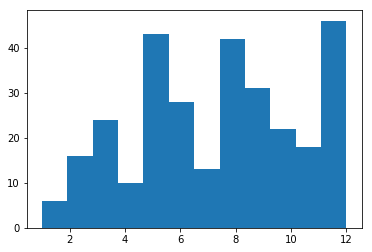

In [67]:
plt.hist(force3.month, bins=12);

In [47]:
list(big_gdbr)

[145, 132, 131, 5361, 0, 1, 5359, 5360, 2, 3]

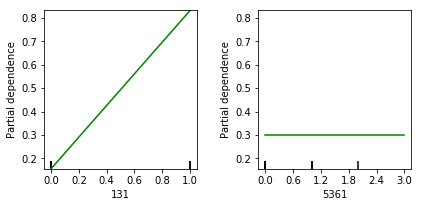

In [49]:

# make plots
my_plots = plot_partial_dependence(gdbr,       
                                   features=[131, 5361], # column numbers of plots to show
                                   X=X,            # raw predictors data.
                                   #feature_names=['day', 'month', 'day_of_week'],
                                   target=["Level 1 - Use of Force"],# for multi-class must use label
                                   grid_resolution=10)

In [50]:
#gdbr.predict(X_test) 
#gdbr.predict_proba(X_test)
gdbr.score(X_test, y_test)

0.7717512032580526

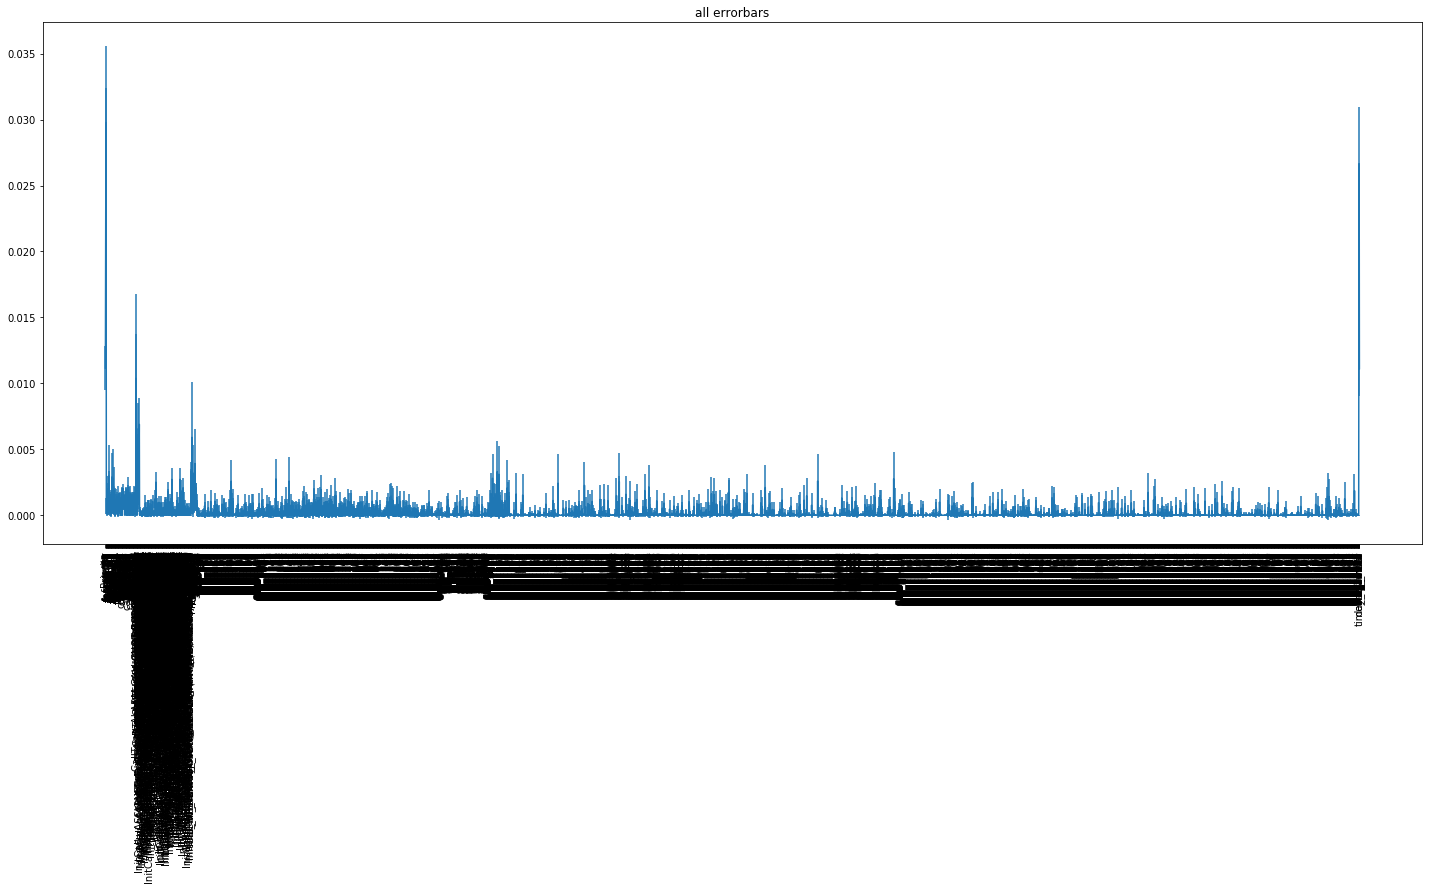

In [51]:

importance = np.std([tree.feature_importances_
                            for tree in clf.estimators_], axis=0)

r = range(importance.shape[0])
f = clf.feature_importances_
yerr = importance

# Extend the code to find the standard deviation of the importance for each feature across all trees. 
fig, ax = plt.subplots(1,1, figsize=(20,8), sharex=True)
#axs.flatten()

ax.errorbar(r,f, yerr=yerr)
ax.set_title('all errorbars')


#fig.suptitle('Errors')

plt.tight_layout()
plt.xticks(np.arange(len(r)), X.columns, rotation="vertical")
plt.show();
#plt.bar(r, f, yerr=yerr, align="center");




In [ ]:
'''force3.Incident_Num.value_counts()
t = force3[force3["Incident_Num"] == 12308]
#t.drop_duplicates("CAD_Event_Number", inplace=True) # 'force_beat', 'calls_beat'
len(t.CAD_Event_Number.value_counts()), len(t)
t2 = t[t.force_beat.values == t.calls_beat.values]
t2'''

'''force3 = merged[merged.Force_Level == "Level 3 - Use of Force"]
force2 = merged[merged.Force_Level == "Level 2 - Use of Force"]
force1 = merged[merged.Force_Level == "Level 1 - Use of Force"]
len(force3), len(force2), len(force1), len(merged)'''

'''# group by incident number first

x = force3.Subject_Race.value_counts()
lst = list(x.values)
plt.bar(np.arange(7), lst)
#plt.xticks([])
#plt.xticks()

plt.xticks((0,1, 2, 3,4,5,6), ('White', 'Black or African American ', 'Not Specified ','Hispanic or Latino',
                               'Asian','American Indian/Alaska Native ','Nat Hawaiian/Oth Pac Islander'), 
          rotation='vertical')
plt.title("Level 3 Force by Race 2014-2019");'''

In [ ]:
'''force3beats = force3[force3.force_beat.values == force3.calls_beat.values]
len(force3beats)
f3b = force3beats.drop(["index", "Force_Level", "Precinct"], axis=1)
f3b.drop("Sector", axis=1, inplace=True)
#f3b '''

In [ ]:
'''#rev_df.drop(["Subject_Gender", "Subject_Race"], axis=1, inplace=True)
rev_df.info(verbose=True)'''

In [ ]:
'''y = force3.Subject_Gender.value_counts()
lst = list(y.values)
plt.bar(np.arange(2), lst)
#plt.xticks([])
#plt.xticks()

plt.xticks((0,1), ('Male', 'Female'), 
          rotation='horizontal')
plt.title("Level 3 Force by Gender 2014-2019");'''

In [ ]:

fig, ax = plt.subplots(1,1, figsize=(20,12))
fct = force3.Final_Call_Type.value_counts()
lst = list(fct.values)
plt.bar(np.arange(99), lst)
#plt.xticks([])
#plt.xticks()

plt.xticks(np.arange(99), lst,  rotation='vertical')
plt.title("Level 3 Force by Final Call Type 2014-2019");